In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from wbfm.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np

from skimage.measure import regionprops


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-tracklet_wiggle/project_config.yaml"
fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-newseg-2021_11_17/project_config.yaml"

project_data = ProjectData.load_final_project_data_from_config(fname)

Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm3-newseg-2021_11_17 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: True
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



In [7]:
img = np.max(project_data.red_data[0, ...], axis=0)

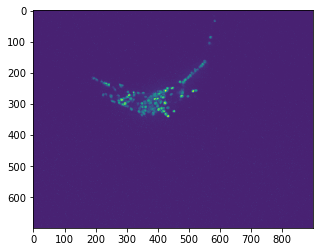

In [8]:
plt.imshow(img)

In [168]:
import cv2
import skimage
import skimage.filters
from skimage.morphology import disk
from sklearn.linear_model import RANSACRegressor, LinearRegression
from skimage.morphology import skeletonize
from skimage.filters import threshold_otsu


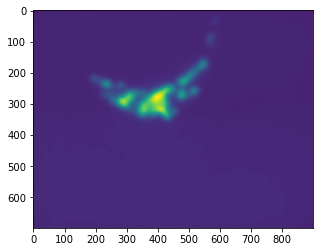

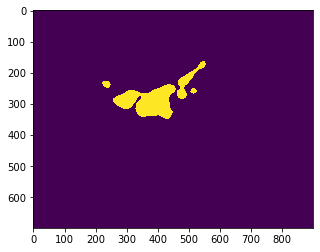

In [179]:
# img_filter = skimage.filters.median(img_binary, disk(5))
img_filter = skimage.filters.gaussian(img, 10)
thresh = threshold_otsu(img_filter)
img_binary = (img_filter > thresh).astype(int)

plt.imshow(img_filter)
plt.figure()
plt.imshow(img_binary)

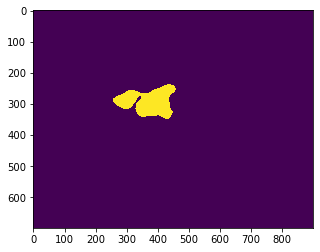

In [180]:
from skimage.measure import label

def get_largest_cc(segmentation):
    labels = label(segmentation)
    unique, counts = np.unique(labels, return_counts=True)
    list_seg=list(zip(unique, counts))[1:] # the 0 label is by default background so take the rest
    largest=max(list_seg, key=lambda x:x[1])[0]
    labels_max=(labels == largest).astype(int)
    return labels_max

plt.imshow(get_largest_cc(img_binary))

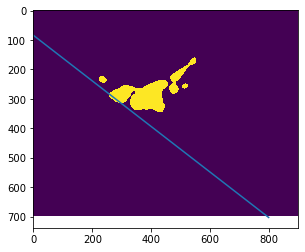

In [256]:
x, y = np.where(get_largest_cc(img_binary))
# x, y = np.where(img_filter)
x, y = np.expand_dims(x, axis=1), np.expand_dims(y, axis=1)
model = RANSACRegressor()
model.fit(x, y)
x_line = np.expand_dims(np.arange(800), axis=1)
y_line = model.predict(x_line)

plt.imshow(img_binary)
plt.plot(x_line, 700-y_line)

In [154]:
def get_center_line(i, to_plot=True):
    img = np.max(project_data.red_data[i, ...], axis=0)
    
    thresh = 0.1
    img_filter = skimage.filters.gaussian(img, 5)
    img_binary = (img_filter > thresh).astype(int)
    
    x, y = np.where(img_filter)
    x, y = np.expand_dims(x, axis=1), np.expand_dims(y, axis=1)
    model = RANSACRegressor()
    model.fit(x, y)
    x_line = np.expand_dims(np.arange(800), axis=1)
    y_line = model.predict(x_line)
    
    if to_plot:
        plt.imshow(img_binary)
        plt.plot(x_line, 700-y_line)

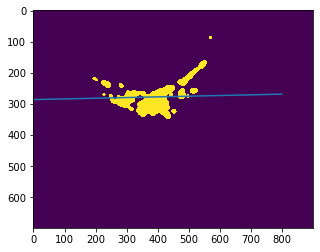

In [160]:
get_center_line(0)

In [161]:
project_data.get_centroids_as_numpy(0)

array([[  4.87711461, 297.77409831, 424.04484606],
       [  4.54208428, 313.3114125 , 433.15373151],
       [  5.85045647, 279.90286483, 417.99879071],
       [  6.15003974, 300.0250527 , 349.52710875],
       [  6.23835199, 308.26352341, 399.32473774],
       [  7.10517582, 333.49121451, 426.35585207],
       [  6.07309064, 324.18153031, 419.68016983],
       [  5.6962963 , 314.94164546, 412.72878145],
       [  7.17393055, 319.08799195, 403.12114746],
       [  6.48218364, 294.69757547, 410.33996559],
       [  5.73987641, 283.90766994, 290.36103235],
       [  7.83086975, 284.06621205, 399.47935159],
       [  7.65175853, 284.19716535, 313.2803937 ],
       [  8.4203579 , 340.46865343, 434.29068347],
       [  8.94296608, 235.99437286, 233.66755193],
       [  8.83660175, 259.77704896, 513.46289785],
       [  7.5946394 , 298.77198307, 393.12962869],
       [  9.08425919, 324.50576746, 452.43139198],
       [  7.09878335, 288.33471589, 322.615927  ],
       [  7.02437859, 274.78646

In [42]:
lines = cv2.HoughLines(img_binary, 10, np.pi / 180, 150, None, 0, 0)

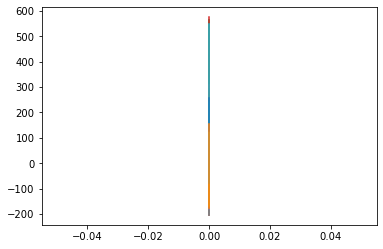

In [62]:
import math
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        plt.plot([0, 0], [x0, y0])
        # cv2.line(img_binary, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
        # break
        

# cv.imshow("Detected Lines (in red) - Standard Hough Line Transform", cdst)

In [55]:
lines

array([[[ 455.       ,    0.9599311]],

       [[ 465.       ,    0.9250245]],

       [[ 475.       ,    0.8901179]],

       ...,

       [[-555.       ,    3.0019662]],

       [[ 285.       ,    1.1170107]],

       [[-235.       ,    2.2863812]]], dtype=float32)